# Capstone: Model Development

<h2 style="color:Blue">Libraries</h2>

In [1]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, f1_score, PrecisionRecallDisplay, auc as skcauc, precision_recall_curve, roc_curve, RocCurveDisplay
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as PipelineImb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import plotly.express as px
import warnings
from scipy.special import exp10
from scipy import stats
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from IPython.display import Markdown as md
from joblib import dump
from joblib import load
import time
import pickle

In [2]:
warnings.filterwarnings('ignore')

<h2 style="color:Blue">Load Data</h2>

In [3]:
churn = pd.read_csv('data/FullChurn.csv')

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4394 entries, 0 to 4393
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        4394 non-null   int64  
 1   IsVIP                     4394 non-null   int64  
 2   CountryCode               4391 non-null   object 
 3   TotalUnits                4394 non-null   int64  
 4   TotalFee                  4394 non-null   float64
 5   Industry                  3414 non-null   object 
 6   Tenure                    4394 non-null   int64  
 7   UsersCount                4394 non-null   int64  
 8   Churn                     4394 non-null   int64  
 9   ChurnPerc                 4394 non-null   float64
 10  TicketsCount              4394 non-null   int64  
 11  TicketsPriorityMean       4394 non-null   float64
 12  TicketsClosedCount        4394 non-null   int64  
 13  SLATimeUsedTotal          4394 non-null   int64  
 14  SLATimeU

In [5]:
churn.head()

ID  IsVIP CountryCode  TotalUnits  TotalFee  \
0  356      0          US          99   2622.58   
1  445      0          US          12    285.98   
2  727      0          US          28    325.00   
3  947      0          US          10    382.98   
4  968      0          US          34    899.70   

                                 Industry  Tenure  UsersCount  Churn  \
0                                     NaN     214           1      1   
1                                     NaN     213           2      1   
2                                     NaN     208           4      0   
3  Utilities: Gas and Electric Industries     206           1      1   
4                                     NaN     206           4      0   

   ChurnPerc  ...  FatigueMonitorCount  FuelSensorCount  PowerOnEventsCount  \
0     100.00  ...                    0                0               40433   
1     100.00  ...                    0                0                  10   
2      73.97  ...                    0                0                 251   
3     100.00  ...                    0                0                9584   
4      32.16  ...                    0                0                3902   

   PricingCancelCount  ClosedBussCancelCount  NoPaymentCancelCount  \
0                   0                      0                     0   
1                   0                      0                     0   
2                   0                      0                     0   
3                   0                      1                     0   
4                   0                      0                     0   

   SoldVehicleCancelCount  NoUsedVehicleCancelCount  MultHWCasesCancelCount  \
0                       1                         3                       0   
1                       0                         0                       0   
2                       0                         0                       0   
3                       0                         0                       0   
4                       0                         0                       0   

   NoUsedCancelCount  
0                  4  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 31 columns]

ID: Codigo de identificacion unico de la empresa
IsVIP: Indica si el cliente es VIP
CountryCode: Codigo de pais del cliente
TotalUnits: Cantidad de unidades GPS que ha adquirido el cliente
TotalFee: Cargo total del servicio prestado en dolares USD
Industry: Industria a la que pertenece el cliente
Tenure: el tiempo de permanencia del clienteen meses
UsersCount: conteo de usuario que tiene el cliente en la plataforma
Churn: Variable objetivo, 1: Churn, 0: Not Churn
ChurnPerc: Porcentaje de unidades en Churn
TicketsCount: Conteo de casos de soporte hasta la fecha
TicketsPriorityMean: Prioridad media de los casos de soporte(1: baja, 2: normal, 3: alta)
TicketsClosedCount: conteo de casos de soporte cerrados
SLATimeUsedTotal: Tiempo de SLA Usado total que es resultado de la suma del tiempo de SLA de cada caso(cada caso tiene un tiempo maximo de atencion)
SLATimeUsedMean: Tiempo medio de SLA para todos los casos del cliente
SLAPercentageTotal: Porcentaje total que es un resultado de la suma de porcentaje SLA gastado en cada caso(un caso que sobrepase el 100% de sl es que el excedio el tiempo total maximo establecido previamente para ese caso)
SLAPercentageMean: Porcentaje medio de uso de SLA
NonCompliantSLACount: Conteo de casos que no complieron el SLA
RMACount: Conteo de casos de retorno al fabricante por cada cliente en caso de garantia
RMAUnitsCount: Conteo de unidades de retorno al fabricante por cada cliente
MDVRCount: Conteno de camaras MDVR que posee el cliente
FatigueMonitorCount: Conteo de sensores de fatiga que posee el cliente 
FuelSensorCount: Conteo de sensores de combustible que posee el cliente 
PowerOnEventsCount: Conteo de eventos de apagado y encendido de las unidades GPS que posee el cliente
PricingCancelCount: Conteo de peticiones de cancelacion de unidades del cliente por motivos de precio muy alto del servicio
ClosedBussCancelCount: Conteo de peticiones de cancelacion de unidades del cliente por motivos de cierre del negocio o bancarota
NoPaymentCancelCount: Conteo de peticiones de cancelacion de unidades del cliente debido a no pago de facturas
SoldVehicleCancelCount: Conteo de peticiones de cancelacion de unidades del cliente debido a venta de vehiculos
NoUsedVehicleCancelCount: Conteo de peticiones de cancelacion de unidades del cliente debido a vehiculos sin utilizar
MultHWCasesCancelCount: Conteo de peticiones de cancelacion de unidades del cliente debido a problemas de hardware en las unidades
NoUsedCancelCount: Conteo de peticiones de cancelacion de unidades del cliente debido a que las unidades no fueron utilizadas por el cliente

<h2 style="color:Blue">Cleaning</h2>

<h3 style="color:Green">Null Analysis</h3>

Analisis de datos y nulos

In [6]:
churn_null = churn.isnull().sum().sort_values().reset_index()
churn_null.columns = ['Feature', 'Count']
churn_null['%'] = round(churn_null['Count'] / len(churn)* 100, 2 )
churn_null

Feature  Count      %
0                         ID      0   0.00
1   NoUsedVehicleCancelCount      0   0.00
2     SoldVehicleCancelCount      0   0.00
3       NoPaymentCancelCount      0   0.00
4      ClosedBussCancelCount      0   0.00
5         PricingCancelCount      0   0.00
6         PowerOnEventsCount      0   0.00
7            FuelSensorCount      0   0.00
8        FatigueMonitorCount      0   0.00
9                  MDVRCount      0   0.00
10             RMAUnitsCount      0   0.00
11                  RMACount      0   0.00
12      NonCompliantSLACount      0   0.00
13         SLAPercentageMean      0   0.00
14    MultHWCasesCancelCount      0   0.00
15        SLAPercentageTotal      0   0.00
16          SLATimeUsedTotal      0   0.00
17        TicketsClosedCount      0   0.00
18       TicketsPriorityMean      0   0.00
19              TicketsCount      0   0.00
20                 ChurnPerc      0   0.00
21                     Churn      0   0.00
22                UsersCount      0   0.00
23                    Tenure      0   0.00
24                  TotalFee      0   0.00
25                TotalUnits      0   0.00
26                     IsVIP      0   0.00
27           SLATimeUsedMean      0   0.00
28         NoUsedCancelCount      0   0.00
29               CountryCode      3   0.07
30                  Industry    980  22.30

Text(0, 0.5, '% Null')

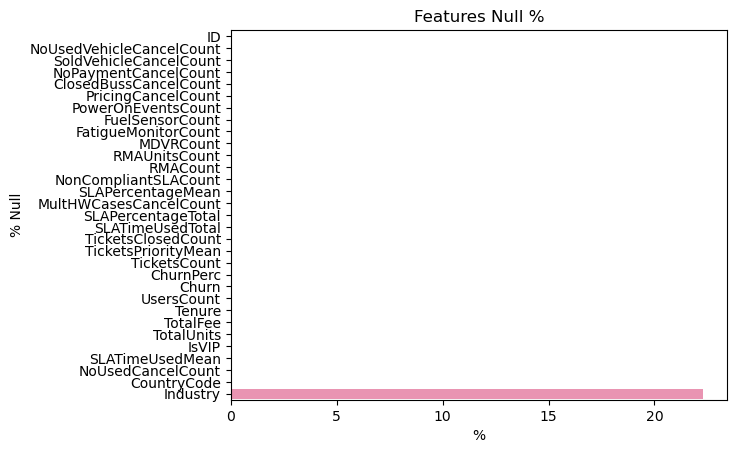

In [7]:
sns.barplot(data = churn_null, y = 'Feature', x = '%')
plt.title('Features Null %')
plt.xticks(rotation=0)
plt.ylabel('% Null')

In [8]:
cats = ['Industry', 'CountryCode']
for cat in cats:
    temp_cat_df = churn[cat].value_counts().reset_index().sort_values(by = 'count', ascending = False)
    display(temp_cat_df)

Industry  count
0                                  Transportation   1314
1                      Transportation & Logistics    658
2                                         Service    394
3                                          Rental    214
4                                      Accounting    166
..                                            ...    ...
61                Property & Real Estate Services      1
60  Oil and Gas Equipment and Services Industries      1
58                          Apparel & Accessories      1
57                     Marketing & Communications      1
67             Toys and Sporting Goods Industries      1

[68 rows x 2 columns]

CountryCode  count
0           CO   2194
1           US   1345
2           PE    679
3           MX    130
4           CA     24
5           PM      6
6           GB      5
7           AU      4
8           CJ      2
9           BF      1
10          Co      1

<h3 style="color:Green">Final Cleaning</h3>

Limpieza de datos

In [9]:
churn_clean = churn.copy()

churn_clean = churn_clean.drop(['ID', 'ChurnPerc'], axis = 1)

churn_clean['CountryCode'] = churn_clean['CountryCode'].fillna(churn_clean["CountryCode"].mode()[0])
churn_clean['Industry'] = churn_clean['Industry'].fillna(churn_clean["Industry"].mode()[0])
churn_clean

IsVIP CountryCode  TotalUnits  TotalFee  \
0         0          US          99   2622.58   
1         0          US          12    285.98   
2         0          US          28    325.00   
3         0          US          10    382.98   
4         0          US          34    899.70   
...     ...         ...         ...       ...   
4389      0          CO           1    149.75   
4390      0          PE           1     19.99   
4391      0          CO           1    149.75   
4392      0          CO           1    149.75   
4393      0          CO           3    449.25   

                                    Industry  Tenure  UsersCount  Churn  \
0                             Transportation     214           1      1   
1                             Transportation     213           2      1   
2                             Transportation     208           4      0   
3     Utilities: Gas and Electric Industries     206           1      1   
4                             Transportation     206           4      0   
...                                      ...     ...         ...    ...   
4389                                 Service       0           1      0   
4390                          Transportation       0           1      0   
4391                                 Service       0           1      0   
4392                                 Service       0           1      0   
4393                                 Service       0           1      0   

      TicketsCount  TicketsPriorityMean  ...  FatigueMonitorCount  \
0               48                  2.0  ...                    0   
1               13                  2.0  ...                    0   
2               17                  2.0  ...                    0   
3                8                  2.0  ...                    0   
4               12                  2.0  ...                    0   
...            ...                  ...  ...                  ...   
4389             0                  2.0  ...                    0   
4390             0                  2.0  ...                    0   
4391             0                  2.0  ...                    0   
4392             0                  2.0  ...                    0   
4393             0                  2.0  ...                    0   

      FuelSensorCount  PowerOnEventsCount  PricingCancelCount  \
0                   0               40433                   0   
1                   0                  10                   0   
2                   0                 251                   0   
3                   0                9584                   0   
4                   0                3902                   0   
...               ...                 ...                 ...   
4389                0                  28                   0   
4390                0                 154                   0   
4391                0                  47                   0   
4392                0                  21                   0   
4393                0                 299                   0   

      ClosedBussCancelCount  NoPaymentCancelCount  SoldVehicleCancelCount  \
0                         0                     0                       1   
1                         0                     0                       0   
2                         0                     0                       0   
3                         1                     0                       0   
4                         0                     0                       0   
...                     ...                   ...                     ...   
4389                      0                     0                       0   
4390                      0                     0                       0   
4391                      0                     0                       0   
4392                      0                     0                       0   
4393                      0                     0          

<h3 style="color:Green">Duplicates</h3>

Analisis de duplicados

In [10]:
duplicate_count = churn_clean.duplicated().value_counts()
duplicates_per = round(duplicate_count[0] / len(churn_clean) * 100, 2)
no_duplicates_per = round(duplicate_count[1] / len(churn_clean) * 100, 2)
print(f"No Duplicates: {duplicate_count[0]} ({duplicates_per}%)")
print(f"Duplicates: {duplicate_count[1]} ({no_duplicates_per}%)")

No Duplicates: 4311 (98.11%)
Duplicates: 83 (1.89%)


In [11]:
#churn_clean = churn_clean.drop_duplicates()

<h2 style="color:Blue">Balance And Correlations</h2>

<h3 style="color:Green">Balance</h3>

Churn  proportion
0      0    0.553254
1      1    0.446746

Text(0, 0.5, 'Proportion')

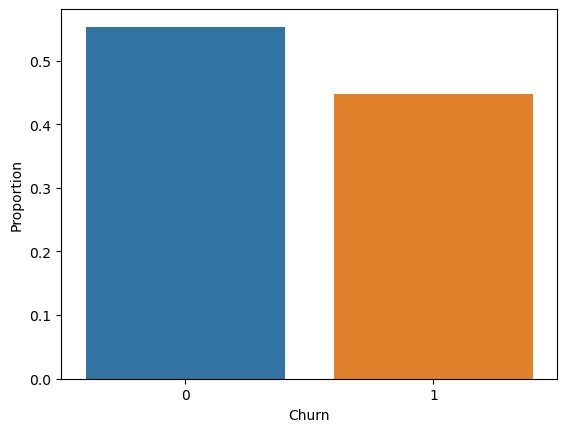

In [12]:
values_ct = churn_clean['Churn'].value_counts(normalize = True)
values_ct = values_ct.reset_index()
display(values_ct)
sns.barplot(values_ct, x = 'Churn', y = 'proportion')
plt.ylabel('Proportion')

Los datos estan poco desbalanceados segun la grafica anterior.

<h3 style="color:Green">Correlations</h3>

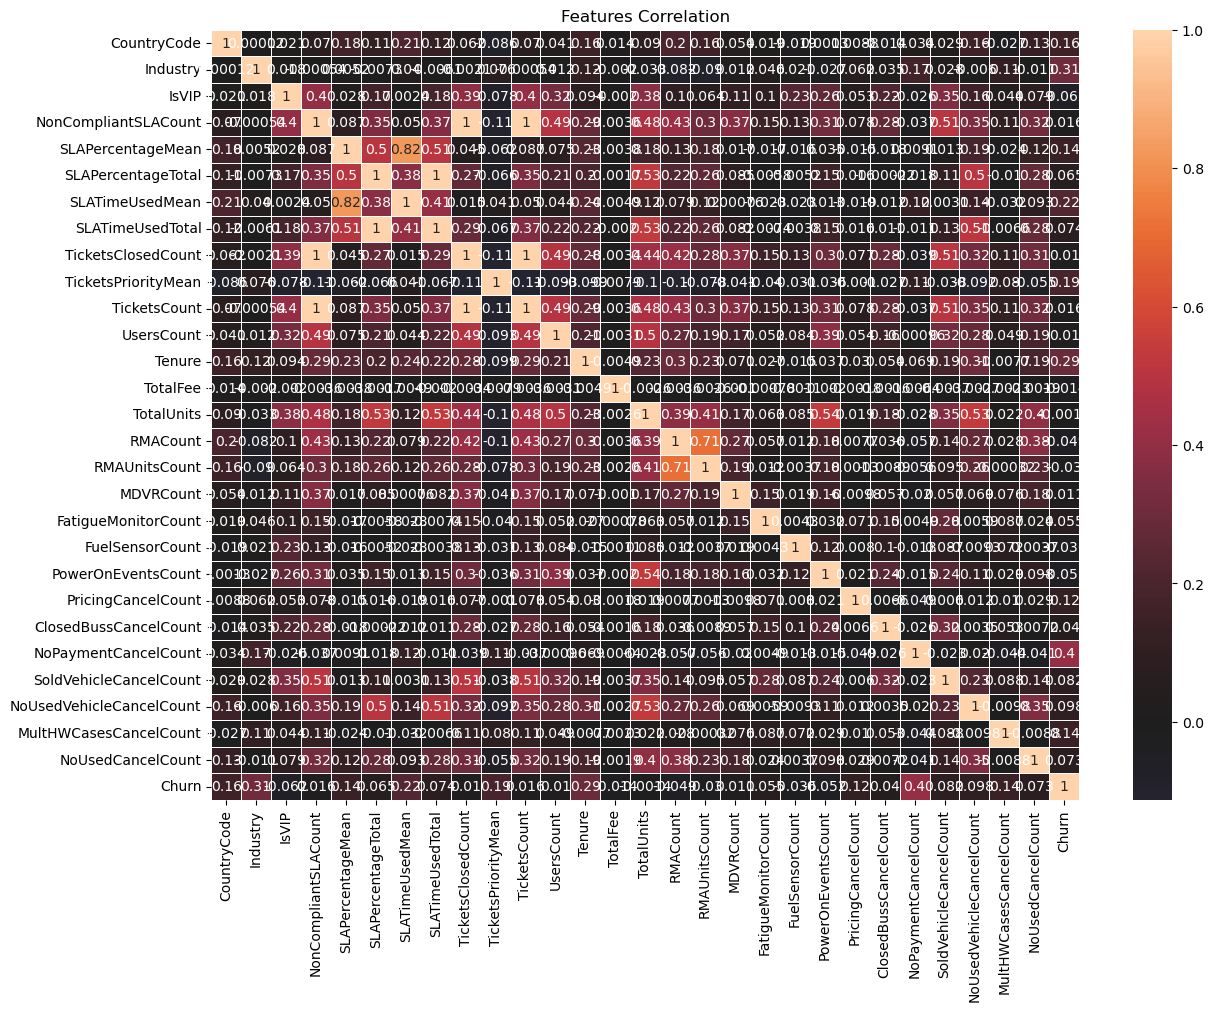

In [13]:
cats = ['CountryCode' , 'Industry']
trg_enc = TargetEncoder()
churn_corr = pd.concat([trg_enc.fit_transform(churn_clean[cats] , churn_clean["Churn"]), 
                          churn_clean[['IsVIP', 'NonCompliantSLACount', 'SLAPercentageMean', 'SLAPercentageTotal', 'SLATimeUsedMean', 'SLATimeUsedTotal', 'TicketsClosedCount', \
                                          'TicketsPriorityMean', 'TicketsCount', 'UsersCount', 'Tenure', 'TotalFee','TotalUnits', 'RMACount', 'RMAUnitsCount',
                                       'MDVRCount','FatigueMonitorCount','FuelSensorCount','PowerOnEventsCount','PricingCancelCount','ClosedBussCancelCount','NoPaymentCancelCount',
                                       'SoldVehicleCancelCount','NoUsedVehicleCancelCount', 'MultHWCasesCancelCount','NoUsedCancelCount','Churn']]], axis = 1).corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(churn_corr, center = 0, linewidth = .5, annot = True).set(title='Features Correlation');

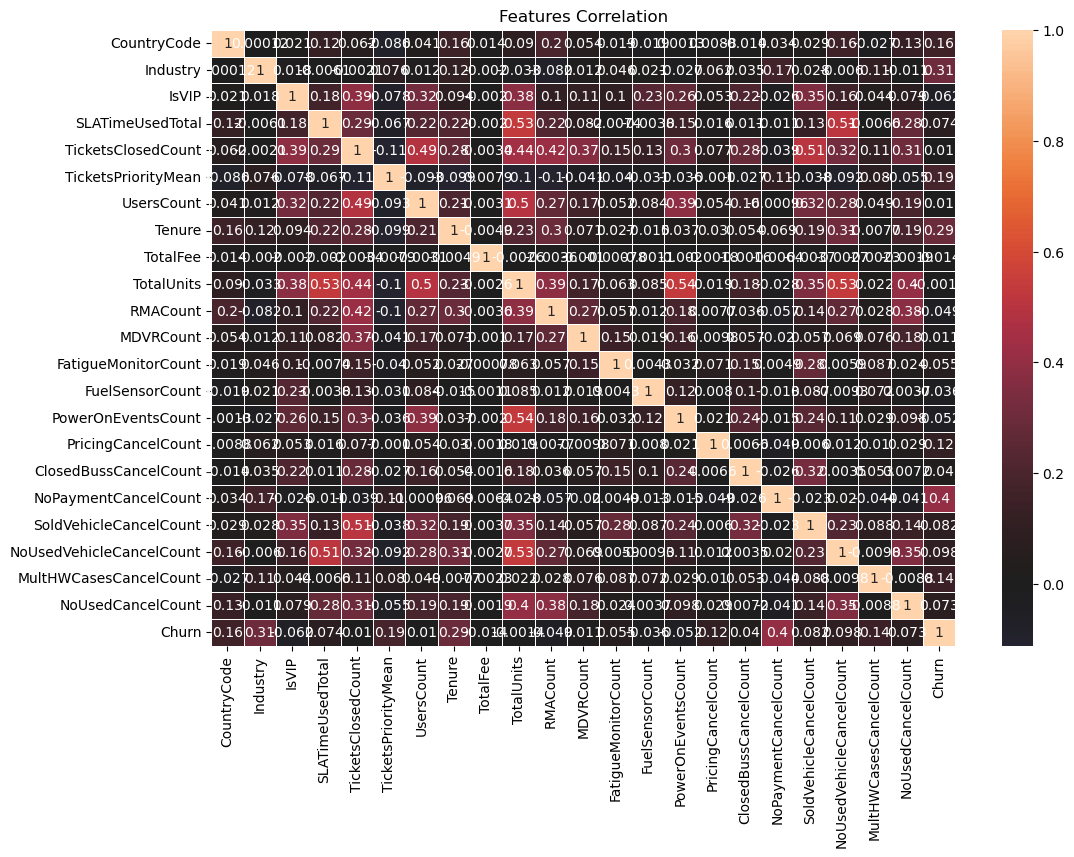

In [14]:
cats = ['CountryCode' , 'Industry']
trg_enc = TargetEncoder()
churn_corr = pd.concat([trg_enc.fit_transform(churn_clean[cats] , churn_clean["Churn"]), 
                          churn_clean[['IsVIP', 'SLATimeUsedTotal', 'TicketsClosedCount', \
                                          'TicketsPriorityMean', 'UsersCount', 'Tenure', 'TotalFee','TotalUnits', 'RMACount', 
                                       'MDVRCount','FatigueMonitorCount','FuelSensorCount','PowerOnEventsCount','PricingCancelCount','ClosedBussCancelCount','NoPaymentCancelCount',
                                        'SoldVehicleCancelCount','NoUsedVehicleCancelCount','MultHWCasesCancelCount','NoUsedCancelCount','Churn']]], axis = 1).corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(churn_corr, center = 0, linewidth = .5, annot = True).set(title='Features Correlation');

Se eliminan algunas columnas con una correlacion = 1

<h2 style="color:Blue">Variables and Methods</h2>

Creacion de alguna variables generales y metodos de graficacion

In [15]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
time_list = []
method = []
random_state = 40
oversampling = ADASYN()

In [16]:
#Confusion matrix plot
def getConfusionMatrix(y_test, y_test_pred, display_labels):
    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=display_labels)
    disp.plot()
    plt.show()

In [17]:
#Gets the scores for each model
def getScores(y_test, y_test_pred):
    ps = precision_score(y_test, y_test_pred)
    rc = recall_score(y_test, y_test_pred)
    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    scores = pd.DataFrame({'Scores':['Precision', 'Recall', 'Accuracy', 'F1'], 'Values' : [ps, rc, acc, f1]})
    display(scores)
    sns.barplot(scores, x = 'Scores', y = 'Values')
    return (ps, rc, acc, f1)

In [18]:
#Draw the Lift plot
def plot_lift_curve(y_val, y_pred, step=0.01):
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    axis.grid()
    plt.title('Lift Curve')
    plt.show()

In [19]:
#Draw the AUC and Recall-Precision plot
def getCurves(X_test, estimator):
    test_predictions = estimator.predict_proba(X_test)
    y_lb_test = np.where(y_test == 1, 'Subscribed', 'Not subscribed')
    ig, ax = plt.subplots(1, 2)
    #fig.set_size_inches(12, 12)
    
    fpr, tpr, thresh_rocs = roc_curve(y_lb_test, test_predictions[:, 1], pos_label='Subscribed')
    roc_auc_value = skcauc(fpr, tpr)
    roc_plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    roc_plt.plot(ax=ax[0])
    ax[0].grid()
    precision, recall, boundaries = precision_recall_curve(y_lb_test, test_predictions[:, 1], pos_label='Subscribed')
    pre_rec_plot = PrecisionRecallDisplay(precision=precision, recall=recall)
    pre_rec_plot.plot(ax=ax[1])
    ax[1].grid()    

    plot_lift_curve(y_test, y_test_pred)

In [20]:
def createBarCategoryPlot(data, title, x_name, y_name, x_label, y_label, rotation = 45):
    plot_data = data.groupby(x_name)[y_name].value_counts().reset_index()
    plot_data = plot_data.sort_values(by=x_name, ascending=False)
    plot_data[y_name] = np.where(plot_data[y_name] == 1 , 'Yes', 'No')
    
    fig = px.bar(plot_data, x=x_name, y='count',
                color=y_name)
    
    fig.update_layout(
        autosize=False,
        width=1200,
        height=600,
        title=title
    )
    fig.show()

<h2 style="color:Blue">Split Data</h2>

In [21]:
X = churn_clean.drop(['Churn', 'SLAPercentageMean', 'TicketsClosedCount', 'SLAPercentageTotal', 'SLATimeUsedMean', 'RMAUnitsCount', 'NonCompliantSLACount'], axis = 1)
y = churn_clean['Churn']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
X_train

IsVIP CountryCode  TotalUnits  TotalFee              Industry  Tenure  \
2942      0          CO           1     29.99        Transportation      26   
1492      0          US           2    199.96        Transportation      70   
1216      0          US           6    143.70            Technology      85   
1052      0          MX           5    149.95        Transportation      95   
3756      0          US           1     19.99        Transportation       9   
...     ...         ...         ...       ...                   ...     ...   
2103      0          CO          11    199.90            Accounting      48   
3603      0          CO           1     29.99        Transportation      11   
3340      0          PE           1     19.99        Transportation      17   
3064      0          CO           1     19.99        Transportation      23   
3398      0          CO          17    509.83  Construction General      15   

      UsersCount  TicketsCount  TicketsPriorityMean  SLATimeUsedTotal  ...  \
2942           1             4                  3.0                 0  ...   
1492           6             2                  2.0               971  ...   
1216           1             1                  3.0            482900  ...   
1052           2             0                  2.0                 0  ...   
3756           1             0                  2.0                 0  ...   
...          ...           ...                  ...               ...  ...   
2103           2            10                  2.0            154646  ...   
3603           1             1                  3.0                 0  ...   
3340           1             3                  3.0                 0  ...   
3064           1             0                  2.0                 0  ...   
3398           1            12                  2.0            172077  ...   

      FatigueMonitorCount  FuelSensorCount  PowerOnEventsCount  \
2942                    0                0               15529   
1492                    0                0                3118   
1216                    0                0                 781   
1052                    0                0                 508   
3756                    0                0                 200   
...                   ...              ...                 ...   
2103                    0                0                6864   
3603                    0                0                  53   
3340                    0                0                1758   
3064                    0                0                1701   
3398                    0               15                7237   

      PricingCancelCount  ClosedBussCancelCount  NoPaymentCancelCount  \
2942                   0                      0                     0   
1492                   0                      0                     0   
1216                   0                      0                     1   
1052                   0                      0                     0   
3756                   0                      0                     0   
...                  ...                    ...                   ...   
2103                   0                      1                     0   
3603                   0                      0                     0   
3340                   0                      0                     0   
3064                   0                      0                     0   
3398                   0                      0                     0   

      SoldVehicleCancelCount  NoUsedVehicleCancelCount  \
2942                       0                         0   
1492                       0                         0   
1216                       0                         0   
1052                       0                         0   
3756                       0                         0   
...                      ...                       ...   
2103                       0                

<h2 style="color:Blue">Models</h2>

<h3 style="color:Green">Dummy Model</h3>

<h4 style="color:Gray">Model Definition</h4>

In [23]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

dm_pipe = Pipeline([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', DummyClassifier(strategy="uniform"))
    ])

dm_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()),
                ('model', DummyClassifier(strategy='uniform'))])

<h4 style="color:Gray">Model Results</h4>

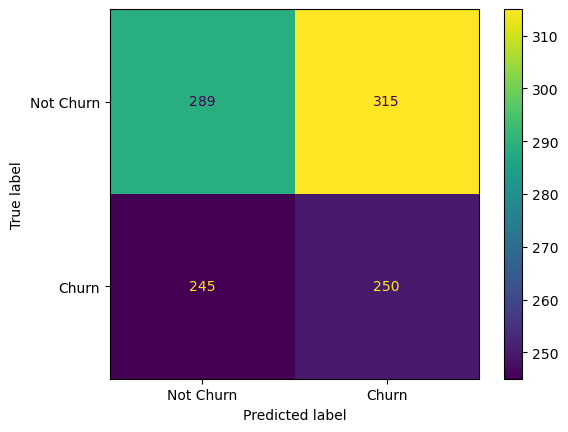

Scores    Values
0  Precision  0.442478
1     Recall  0.505051
2   Accuracy  0.490446
3         F1  0.471698

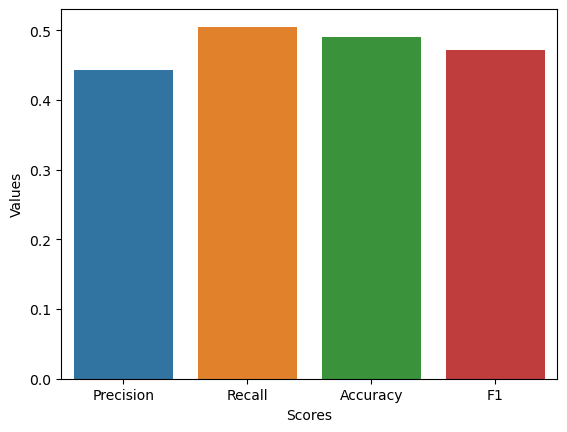

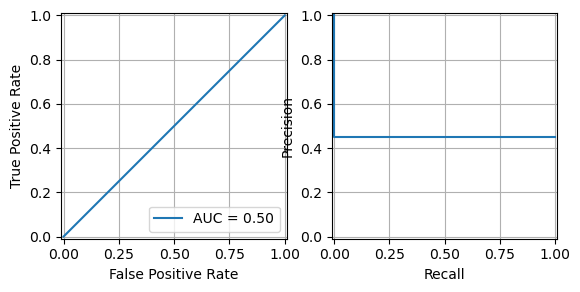

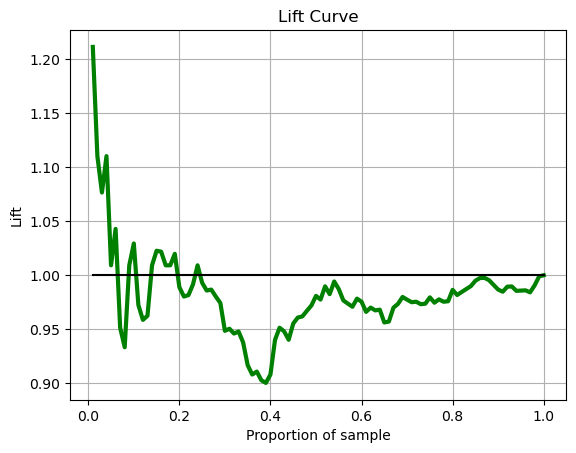

In [24]:
start = time.time()

best_est = dm_pipe
best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Dummy Classifier')

<h3 style="color:Green">Logistic Regression</h3>

<h4 style="color:Gray">Model Definition</h4>

In [25]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

lr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state=random_state, max_iter = 1000))
    ])

lr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    random_state=40, solver='liblinear'))])

<h4 style="color:Gray">Model Results</h4>

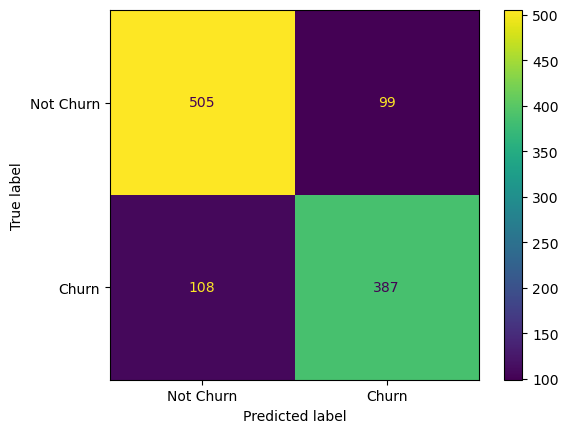

Scores    Values
0  Precision  0.796296
1     Recall  0.781818
2   Accuracy  0.811647
3         F1  0.788991

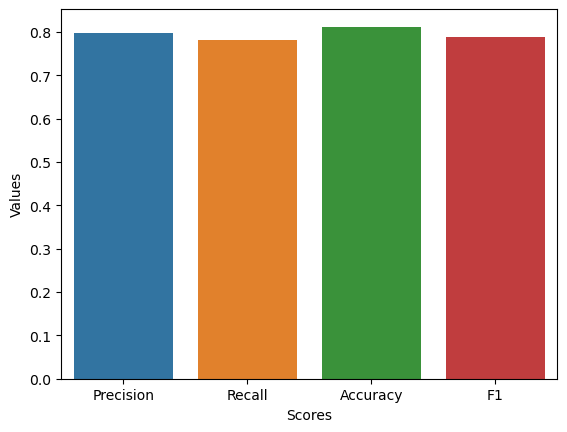

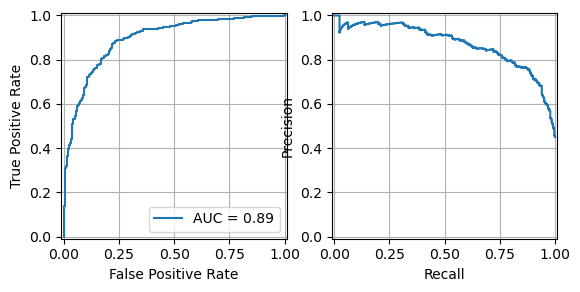

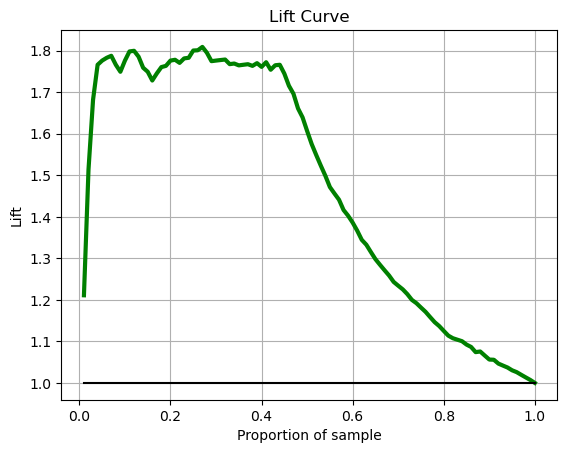

{'model__C': 3.1622776601683795}

In [26]:
start = time.time()

params = {'model__C': np.logspace(-5, .5)}
grid = GridSearchCV(lr_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Logistic Regression')
display(grid.best_params_)

<h3 style="color:Green">KNN</h3>

<h4 style="color:Gray">Model Definition</h4>

In [27]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

k_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model',KNeighborsClassifier())
    ])

k_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', KNeighborsClassifier())])

<h4 style="color:Gray">Model Results</h4>

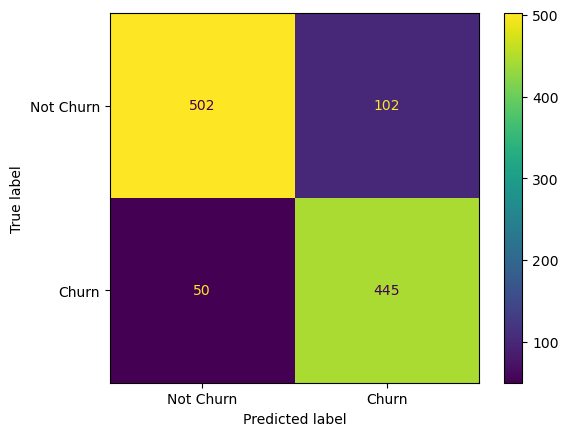

Scores    Values
0  Precision  0.813528
1     Recall  0.898990
2   Accuracy  0.861692
3         F1  0.854127

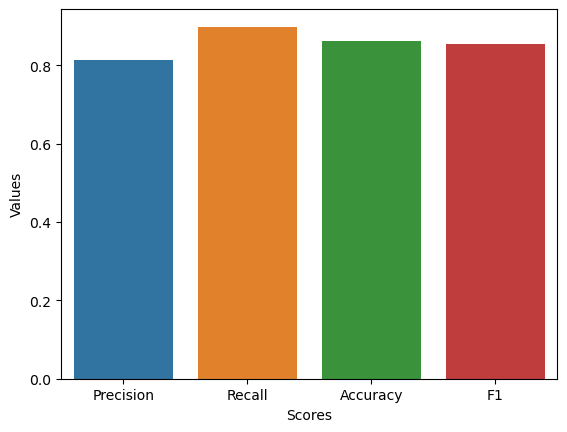

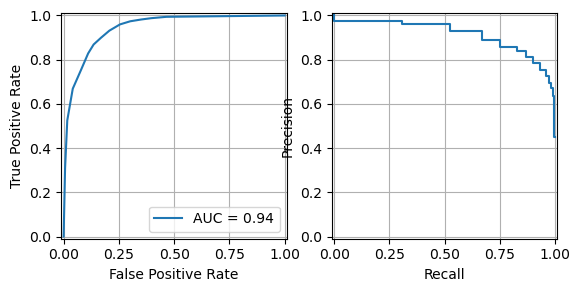

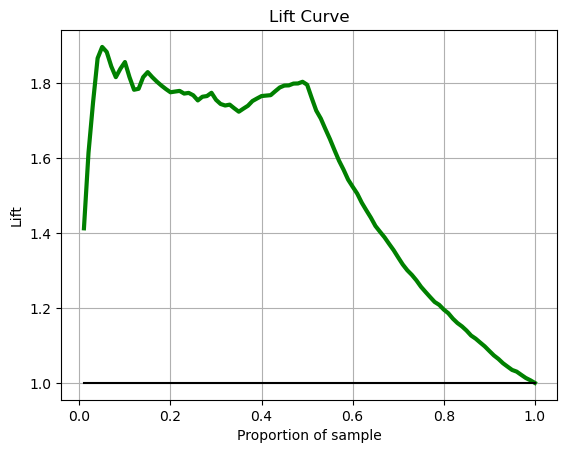

{'model__n_neighbors': 13}

In [28]:
start = time.time()

params = {'model__n_neighbors': range(5, 22, 2)}
grid = GridSearchCV(k_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('KNN')
display(grid.best_params_)

<h3 style="color:Green">Decision Tree</h3>

<h4 style="color:Gray">Model Definition</h4>

In [29]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

t_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', DecisionTreeClassifier(random_state=random_state))
    ])

t_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', DecisionTreeClassifier(random_state=40))])

<h4 style="color:Gray">Model Results</h4>

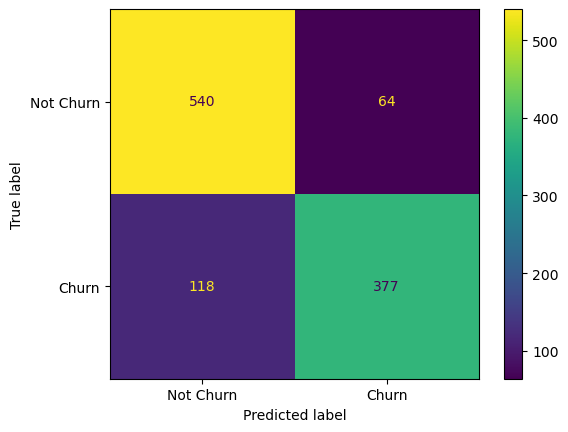

Scores    Values
0  Precision  0.854875
1     Recall  0.761616
2   Accuracy  0.834395
3         F1  0.805556

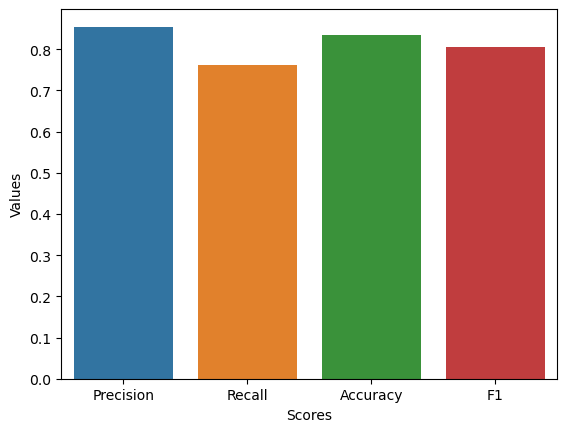

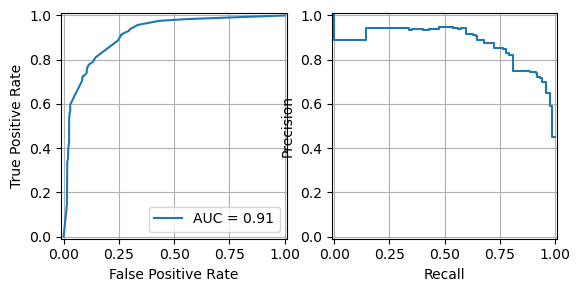

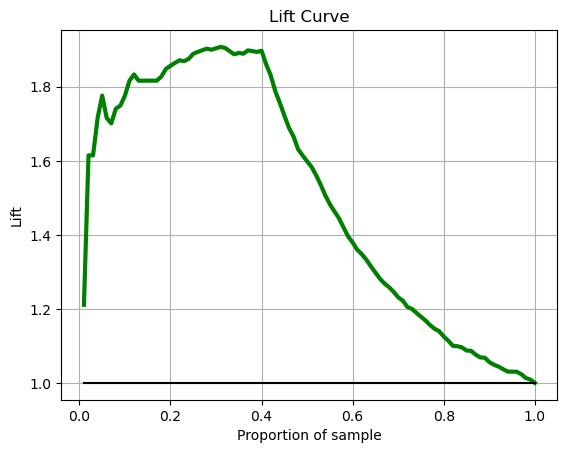

{'model__criterion': 'gini',
 'model__max_depth': 8,
 'model__min_samples_leaf': 6,
 'model__min_samples_split': 2}

In [30]:
start = time.time()

params = {'model__max_depth': [1,2,3,4,5,6,7,8],
         'model__min_samples_split': [2,4,6,8],
          'model__criterion': ['gini', 'entropy'],
          'model__min_samples_leaf': [1,2,4,6]
         }
grid = GridSearchCV(t_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('Decision Tree')
display(grid.best_params_)

<h3 style="color:Green">SVM</h3>

<h4 style="color:Gray">Model Definition</h4>

In [31]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

svr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', SVC(probability=True, coef0=1, gamma='scale', random_state=random_state))
    ])

svr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', SVC(coef0=1, probability=True, random_state=40))])

<h4 style="color:Gray">Model Results</h4>

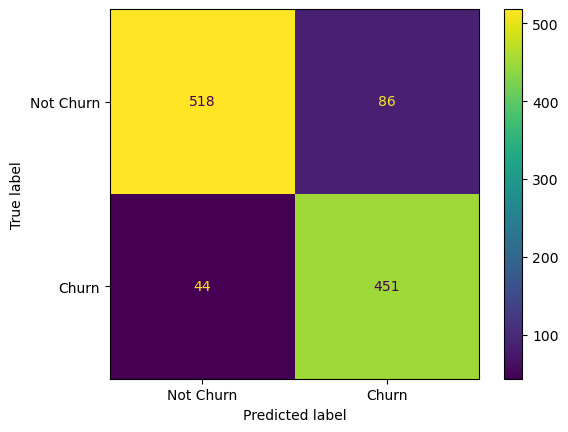

Scores    Values
0  Precision  0.839851
1     Recall  0.911111
2   Accuracy  0.881711
3         F1  0.874031

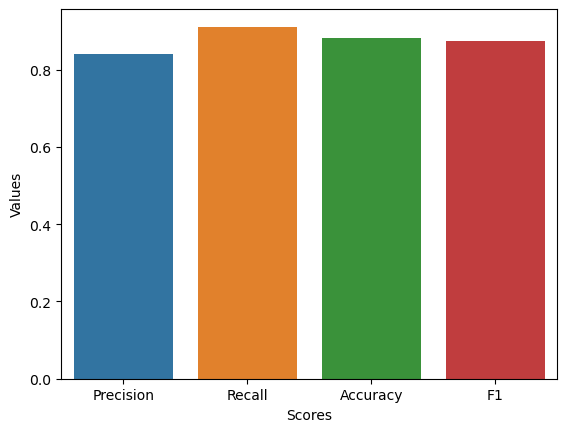

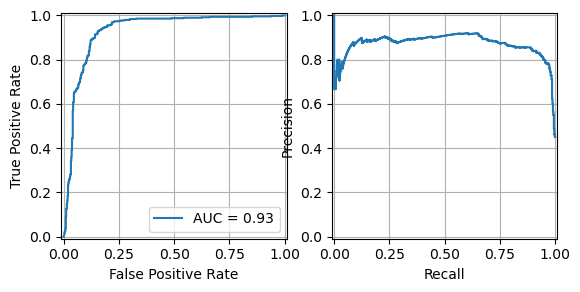

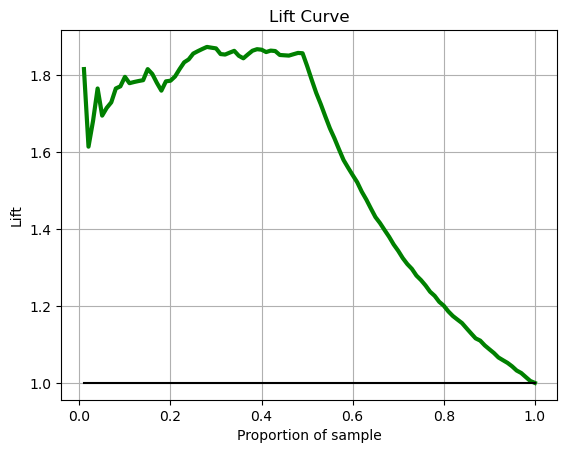

{'model__C': 1, 'model__degree': 3, 'model__kernel': 'poly'}

In [32]:
start = time.time()

params = {'model__C': [0.1, 1, 1,5,10], 'model__kernel': ('poly', 'rbf'),'model__degree' : [2,3,4]}
#grid = HalvingRandomSearchCV(svr_pipe, param_distributions=params, scoring = 'f1').fit(X_train, y_train)
grid = GridSearchCV(svr_pipe, param_grid=params, scoring = 'f1', cv = 3).fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
display(grid.best_params_)
method.append('SVM')
best_estimator_final = best_est

<h3 style="color:Green">SGD</h3>

<h4 style="color:Gray">Model Definition</h4>

In [33]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

sgd_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', SGDClassifier(penalty='l2', max_iter = 1000, random_state=random_state))
    ])

sgd_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', SGDClassifier(random_state=40))])

<h4 style="color:Gray">Model Results</h4>

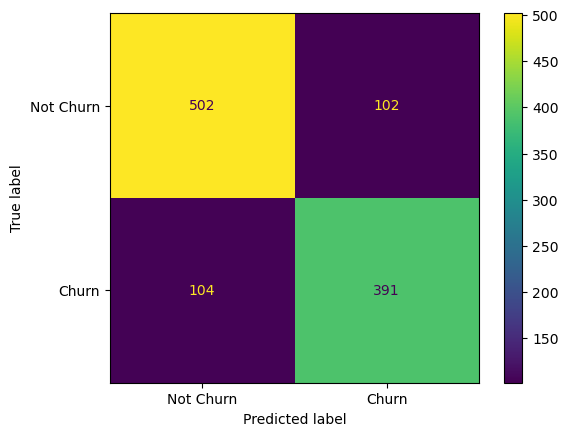

Scores    Values
0  Precision  0.793103
1     Recall  0.789899
2   Accuracy  0.812557
3         F1  0.791498

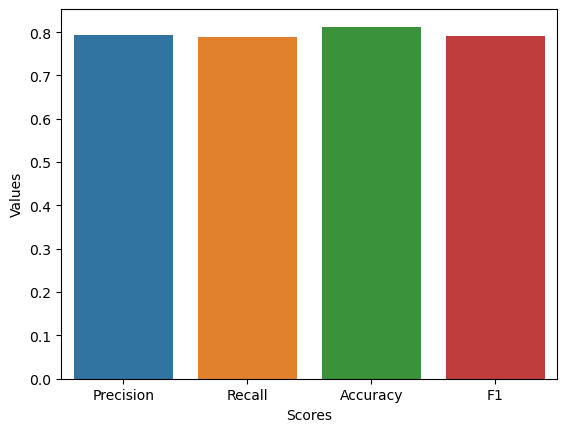

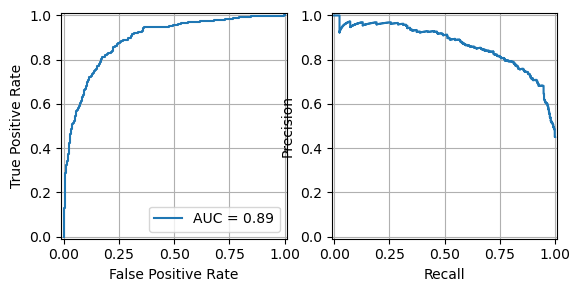

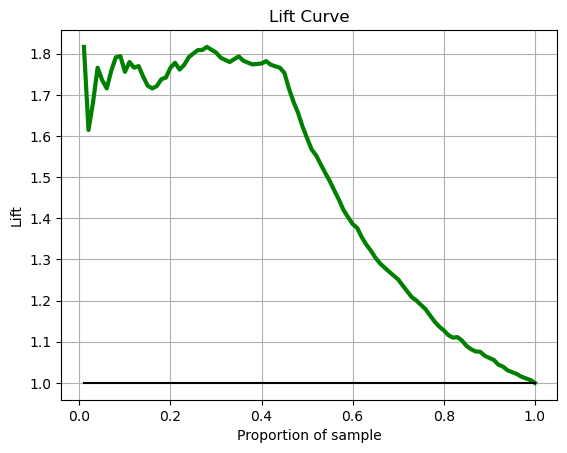

{'model__alpha': 0.001, 'model__loss': 'log_loss'}

In [34]:
start = time.time()

params = {'model__loss': ['log_loss', 'modified_huber'],
         'model__alpha': [0.0001, 0.001]
         }
grid = GridSearchCV(sgd_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_list.append(acc)
f1_list.append(f1)
time_list.append(total_time)
method.append('SGD')
display(grid.best_params_)

<h3 style="color:Green">Results</h3>

Como se puede apreciar en los valores de puntaje de cada modelo, SVC tiene uno de los mejores puntajes entre los demas, seguido de KNN el cual lo sigue muy de cerca. 

In [35]:
results_t1 = pd.DataFrame({'Method': method, 'Accuracy': accuracy_list, 'Recall': recall_list, 'Precision': precision_list, 'F1' : f1_list, 'Fit Time (Sec)' : time_list})
results_t1

Method  Accuracy    Recall  Precision        F1  \
0     Dummy Classifier  0.490446  0.505051   0.442478  0.471698   
1  Logistic Regression  0.811647  0.781818   0.796296  0.788991   
2                  KNN  0.861692  0.898990   0.813528  0.854127   
3        Decision Tree  0.834395  0.761616   0.854875  0.805556   
4                  SVM  0.881711  0.911111   0.839851  0.874031   
5                  SGD  0.812557  0.789899   0.793103  0.791498   

   Fit Time (Sec)  
0        0.016014  
1       23.315452  
2        6.439762  
3      118.041277  
4       54.016376  
5        2.159946

<Axes: xlabel='Method'>

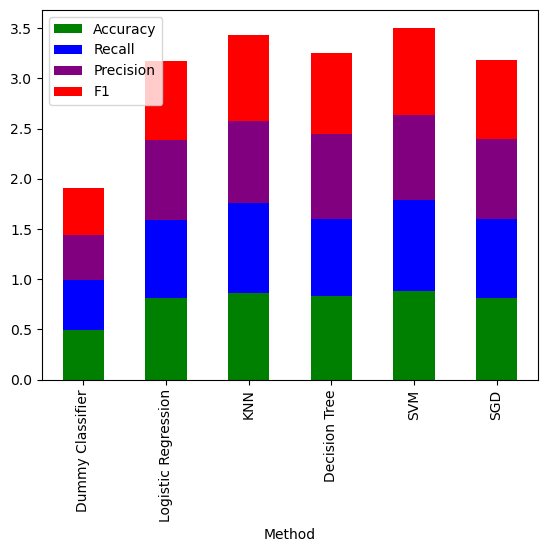

In [37]:
colors = ['green', 'blue', 'purple', 'red']
results_t1.drop('Fit Time (Sec)', axis = 1).set_index('Method').plot(kind='bar', stacked=True, color=colors)

<h2 style="color:Blue">Feature Importance</h2>

In [38]:
best_estimator_final = best_est
importances = permutation_importance(best_estimator_final, X_train, y_train, n_repeats = 10, random_state=40)

In [39]:
importances_tr = dict(zip(X_train.columns, importances.importances_mean))
display(importances_tr)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
display(importances_tr)

import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)

{'IsVIP': 0.002276176024279264,
 'CountryCode': 0.018330804248861965,
 'TotalUnits': 0.0006069802731411555,
 'TotalFee': 9.104704097118166e-05,
 'Industry': 0.01496206373292871,
 'Tenure': 0.07851289833080431,
 'UsersCount': -0.00024279210925638451,
 'TicketsCount': 0.004248861911987889,
 'TicketsPriorityMean': 0.012776934749620671,
 'SLATimeUsedTotal': 0.002610015174506863,
 'RMACount': 0.006191198786039476,
 'MDVRCount': -0.0006373292867981384,
 'FatigueMonitorCount': 0.00145675265553874,
 'FuelSensorCount': 0.0010622154779970194,
 'PowerOnEventsCount': -0.0003338391502275773,
 'PricingCancelCount': 0.009377845220030379,
 'ClosedBussCancelCount': 0.004946889226100204,
 'NoPaymentCancelCount': 0.10986342943854328,
 'SoldVehicleCancelCount': 0.013839150227617636,
 'NoUsedVehicleCancelCount': 0.0008194233687405572,
 'MultHWCasesCancelCount': 0.017936267071320233,
 'NoUsedCancelCount': 0.003945371775417339}

{'NoPaymentCancelCount': 0.10986342943854328,
 'Tenure': 0.07851289833080431,
 'CountryCode': 0.018330804248861965,
 'MultHWCasesCancelCount': 0.017936267071320233,
 'Industry': 0.01496206373292871,
 'SoldVehicleCancelCount': 0.013839150227617636,
 'TicketsPriorityMean': 0.012776934749620671,
 'PricingCancelCount': 0.009377845220030379,
 'RMACount': 0.006191198786039476,
 'ClosedBussCancelCount': 0.004946889226100204,
 'TicketsCount': 0.004248861911987889,
 'NoUsedCancelCount': 0.003945371775417339,
 'SLATimeUsedTotal': 0.002610015174506863,
 'IsVIP': 0.002276176024279264,
 'FatigueMonitorCount': 0.00145675265553874,
 'FuelSensorCount': 0.0010622154779970194,
 'NoUsedVehicleCancelCount': 0.0008194233687405572,
 'TotalUnits': 0.0006069802731411555,
 'TotalFee': 9.104704097118166e-05,
 'UsersCount': -0.00024279210925638451,
 'PowerOnEventsCount': -0.0003338391502275773,
 'MDVRCount': -0.0006373292867981384}

Importances
NoPaymentCancelCount         0.109863
Tenure                       0.078513
CountryCode                  0.018331
MultHWCasesCancelCount       0.017936
Industry                     0.014962
SoldVehicleCancelCount       0.013839
TicketsPriorityMean          0.012777
PricingCancelCount           0.009378
RMACount                     0.006191
ClosedBussCancelCount        0.004947
TicketsCount                 0.004249
NoUsedCancelCount            0.003945
SLATimeUsedTotal             0.002610
IsVIP                        0.002276
FatigueMonitorCount          0.001457
FuelSensorCount              0.001062
NoUsedVehicleCancelCount     0.000819
TotalUnits                   0.000607
TotalFee                     0.000091
UsersCount                  -0.000243
PowerOnEventsCount          -0.000334
MDVRCount                   -0.000637

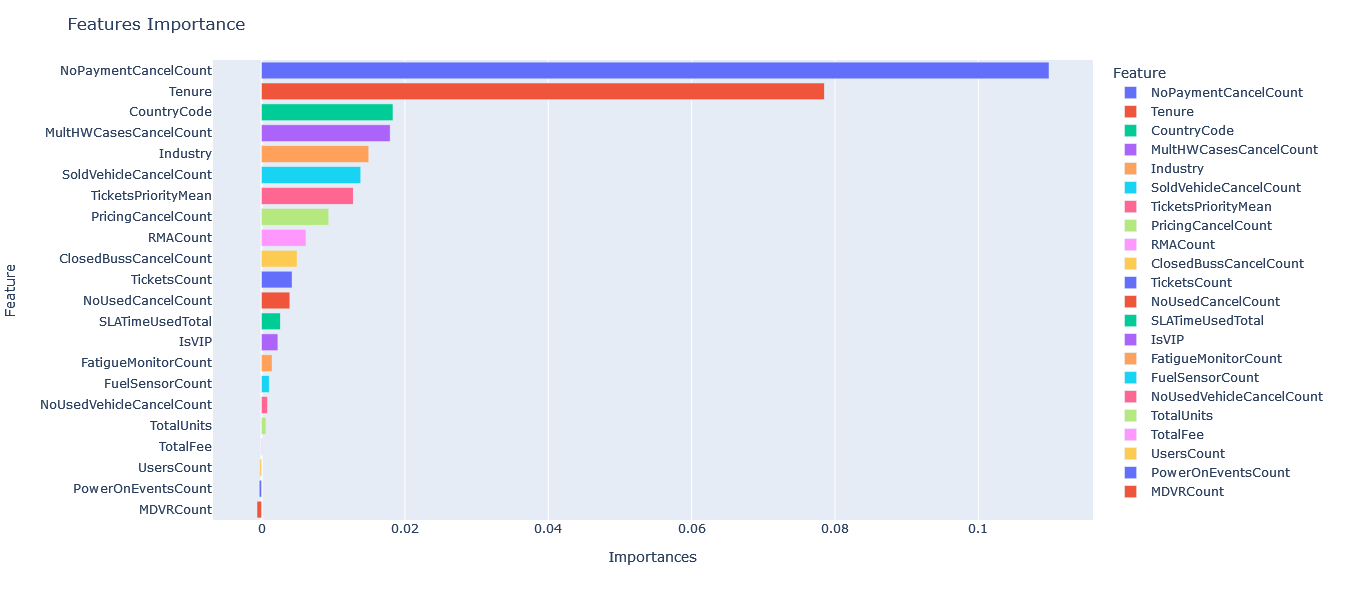

In [40]:
fig = px.bar(import_df.reset_index(), x="Importances", y = 'index', color='index', labels={'index' : 'Feature'})
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Features Importance"
)
fig.show()

Como caracteristica principal tenemos que NoPaymentCancelCount tiene ucho peso a la hora de predecir churn seguido por tenure, esto probablemente se deba que el no pago de los servicio de parte de los clientes es un aliciente bastante poderoso para terminar un contrato de servicios. El ternure es otro caso en el que los clientes mas antiguos son los que mas tienede a irse ya que son los que mas madurez tienen a la hora de decidir si el servicio ofrecido es realmente lo que ellos necesitan.

MultHWCasesCancelCount es bastante interesante ya que es una caracteristica que indica fallos de hardware y es un aliciente bastante importante al moento de un cliente cancelar el servicio. CountryCode es otra caracteristica pero pienso que esta bsatante sesgada ya que la mayoria de los clientes son de LATAM.

<h2 style="color:Blue">Feature Analysis</h2>

<h3 style="color:Green">Churn Count By Industry</h3>

La industria del tranporte es el mayor cliente de la compañia seguido por servicios varios y logistica, es evnidente que esos sectrores son los que mas deben ser tenidos en cuenta al momento de predecir churn.

Industry Churn  count
107                             Transportation    No   1149
108                             Transportation   Yes   1145
109                 Transportation & Logistics   Yes    428
97                                     Service    No    329
110                 Transportation & Logistics    No    230
..                                         ...   ...    ...
87         Pharmaceutical & Medicinal Products   Yes      1
90             Property & Real Estate Services    No      1
45           Environmental Products & Services   Yes      1
71                  Marketing & Communications    No      1
59   Home Equipment and Furnishings Industries    No      1

[118 rows x 3 columns]

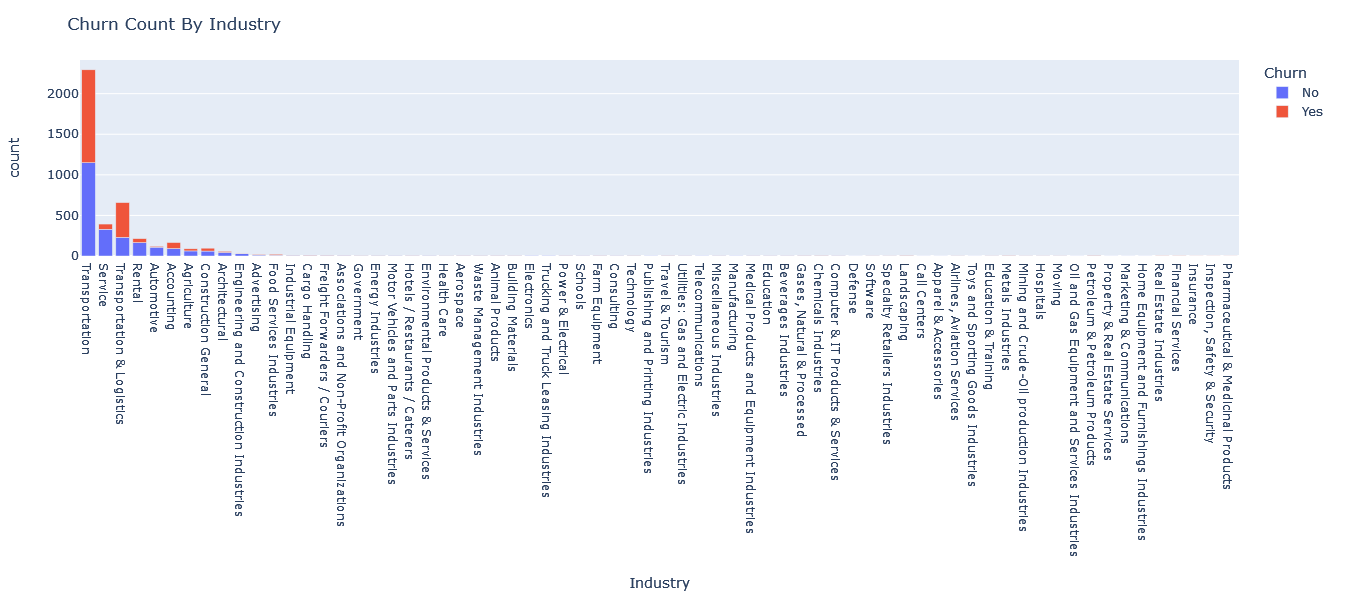

In [41]:
plot_data = churn_clean.groupby('Industry')['Churn'].value_counts().reset_index()
plot_data = plot_data.sort_values(by='count', ascending=False)
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Industry', y='count',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By Industry"
)
fig.show()

<h3 style="color:Green">Churn Mean By Tenure</h3>

El feature de tenure es muy interesante ya que como podemos comprobar en la grafica, el promedio de ternure es mas alto en clientes con churn, eso nos da una idea de que es mas probable de que el cliente cancele mas y mas servicios entrer mas tiempo los haya utilizado. Es necesrio implementar una estrategia mas fuerte que cuide a los clientes antiguos sin descuidar los nuevos.

Churn     Tenure
0    No  46.633484
1   Yes  75.753439

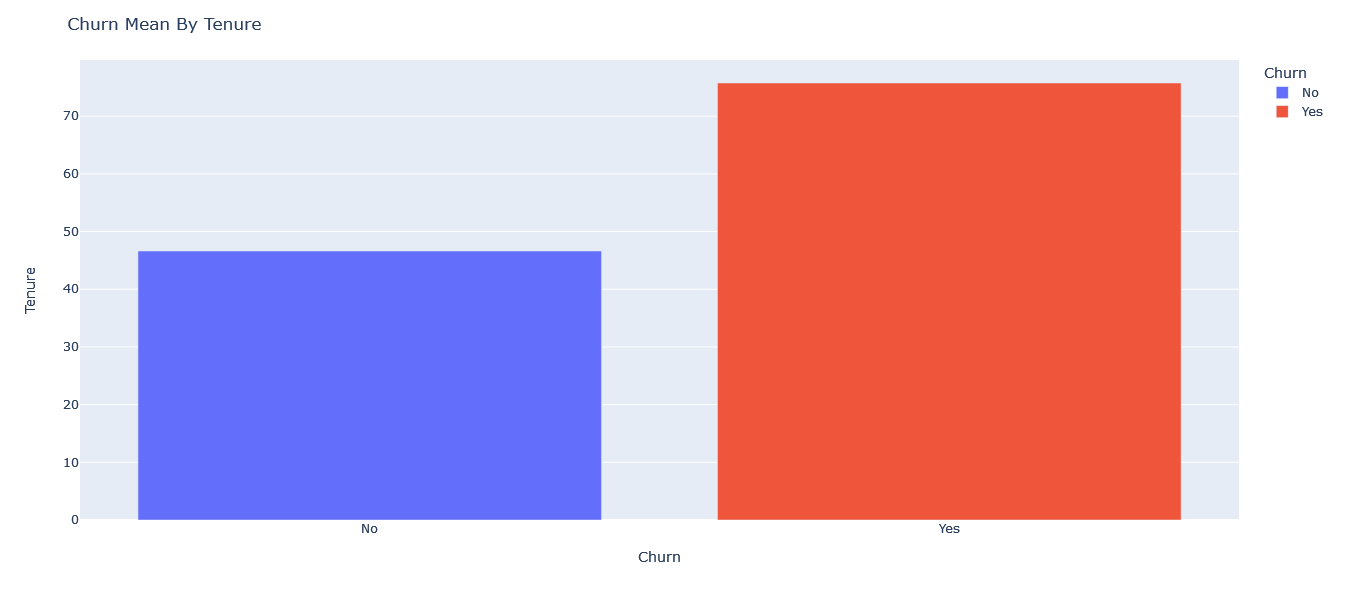

In [42]:
plot_data = churn_clean.groupby('Churn')['Tenure'].mean().reset_index()
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Churn', y='Tenure',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Mean By Tenure"
)
fig.show()

<h3 style="color:Green">Churn Mean By No Payment</h3>

El conteo de cancelaciones de servicio por dejar de pagar el servicio es notorialmente mucho mas alta en clientes con churn, cosa que es natural, la recomendacion es que si un cliente deja de pagar el servicio y la razon es por que el servicio no le parece adecuado, tratar de retenerlo y convercerlo de seguir y abornar el valor adeudado.

Churn  NoPaymentCancelCount
0    No                    68
1   Yes                   724

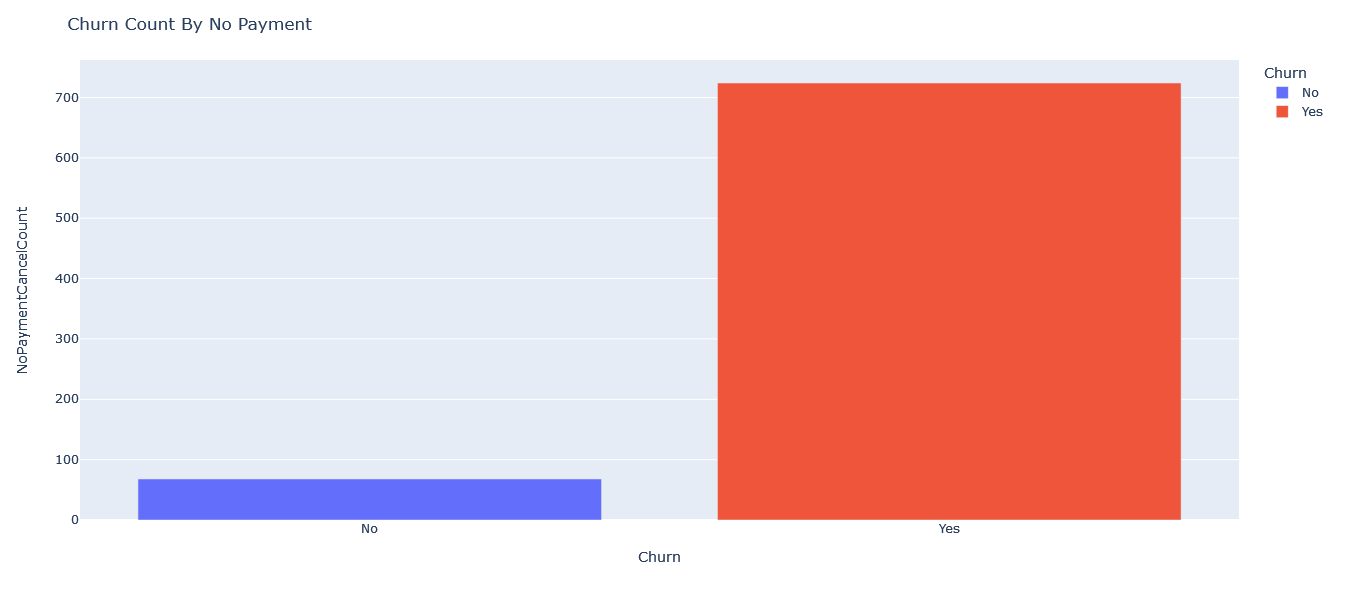

In [43]:
plot_data = churn_clean.groupby('Churn')['NoPaymentCancelCount'].sum().reset_index()
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Churn', y='NoPaymentCancelCount',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By No Payment"
)
fig.show()

<h3 style="color:Green">Churn Count By Country</h3>

Este valor indica que Colombia es el pais que mas churn tiene conr especto a otros, este valor esta algo sesgado ya que USA ya no es un pais objetivo de ventas pero que sigue teniendo clientes fieles, la razon es que USA esta bajo otra marca. La verdadera comparacion es entre Colombia y Peru, y como se puede observar el churn es muy alto en Colombia en comparacion con Peru.

CountryCode  count
4          CO    907
9          US    702
7          PE    317
2          CA     13
6          MX     10
5          GB      5
0          AU      4
8          PM      3
1          BF      1
3          CJ      1

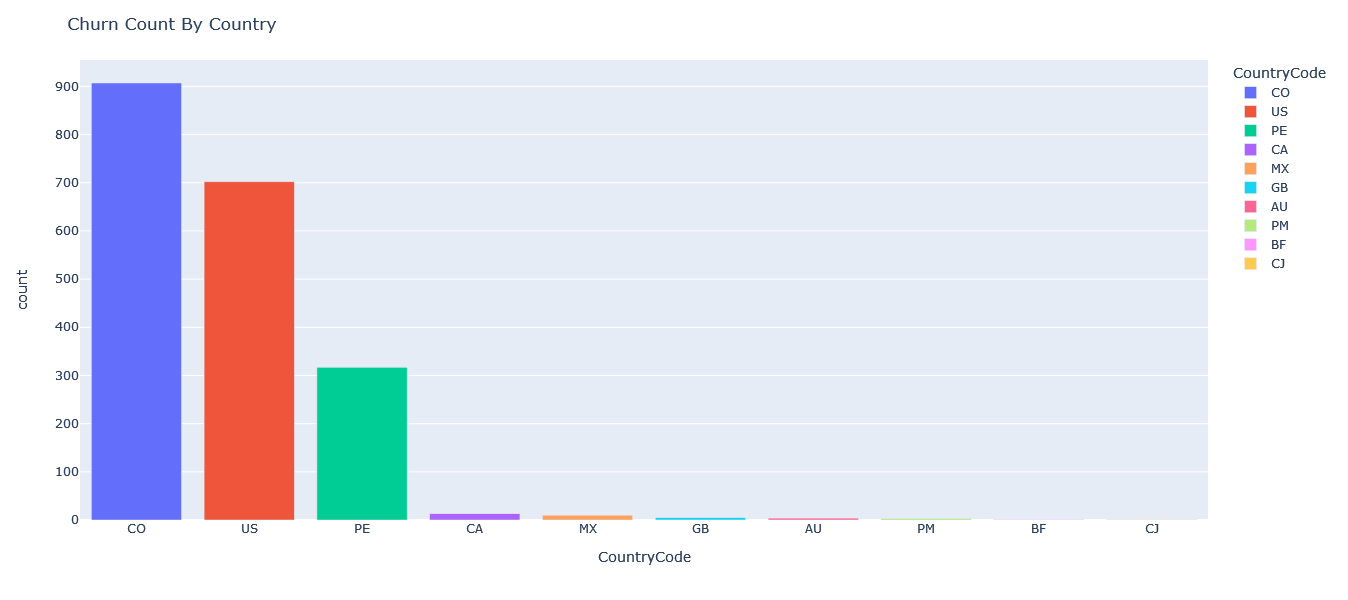

In [44]:
plot_data = churn_clean.loc[churn_clean['Churn'] == 1].groupby('CountryCode')['CountryCode'].value_counts().reset_index()
plot_data = plot_data.sort_values(by='count', ascending=False)
display(plot_data)
fig = px.bar(plot_data, x='CountryCode', y='count',
            color='CountryCode',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By Country"
)
fig.show()

<h3 style="color:Green">Churn Count By RMA Units</h3>

El numeor de RM es mucho mas alto(el doble) en clientes sin churn que en clientes con churn, esto nos da una idea de que RMA es una estrategia válida para retener clientes ya que ellos se sienten bien atendidos cuando las garantias de los productos se hacen efectivas.

Churn  RMACount
0    No       666
1   Yes       360

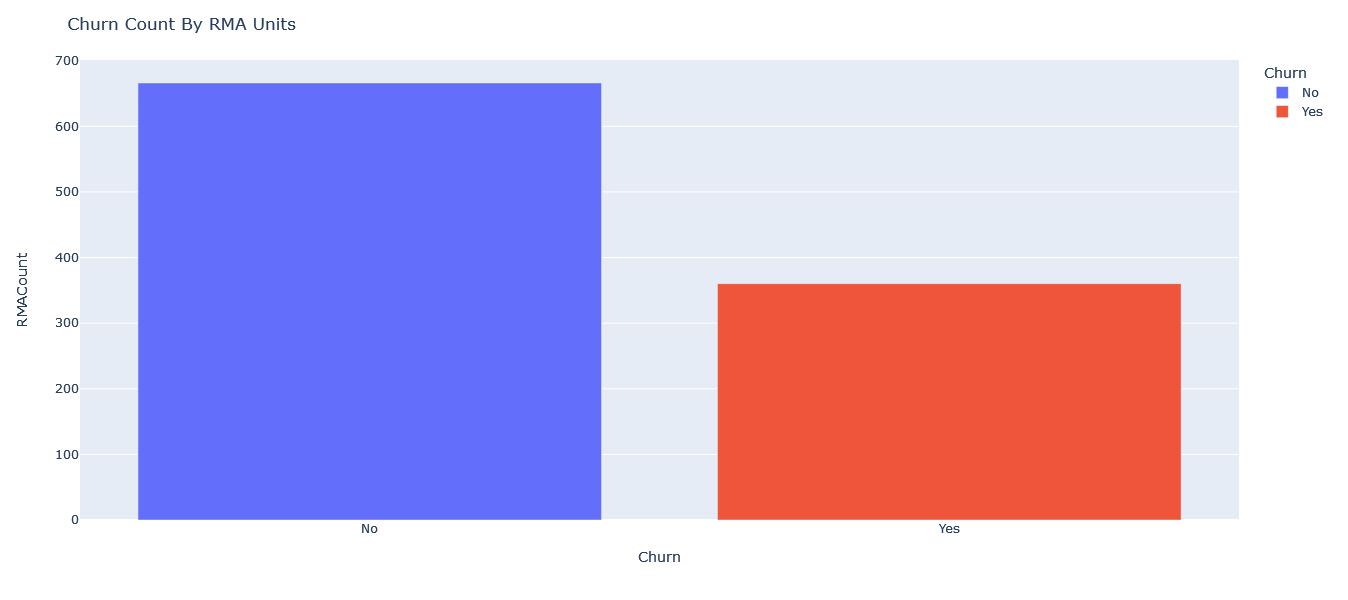

In [45]:
plot_data = churn_clean.groupby('Churn')['RMACount'].sum().reset_index()
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Churn', y='RMACount',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By RMA Units"
)
fig.show()

<h3 style="color:Green">Churn Count By Pricing</h3>

La cancelaciones por costo y precios del servicio es bastante elevada cuando el cliente esta en churn, aqui es aconsejable implementar una estrategia comercial que permita que algunos precios sean mas asequibles para aquellos que estan dispuestos a pagarlos. Tal ves la percepcion de costo-beneficio es mas baja de lo esperado.

Churn  PricingCancelCount
0    No                   6
1   Yes                  73

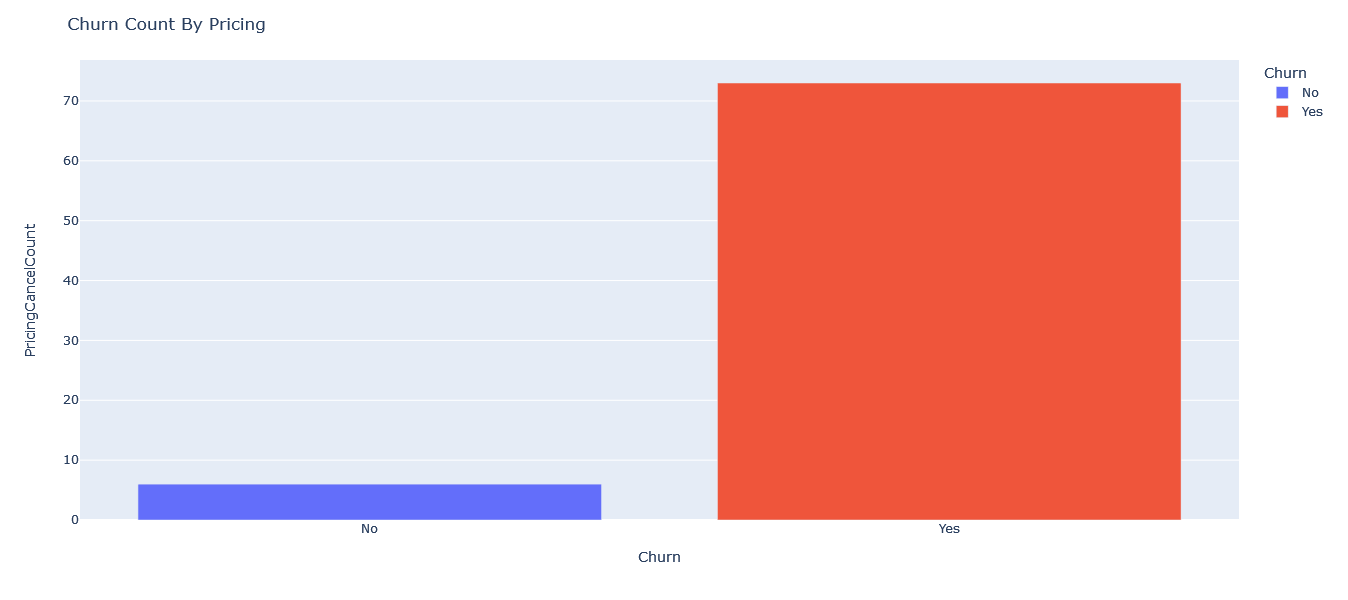

In [46]:
plot_data = churn_clean.groupby('Churn')['PricingCancelCount'].sum().reset_index()
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Churn', y='PricingCancelCount',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By Pricing"
)
fig.show()